# Modelación de flujo de agua subterránea en un medio heterogéneo/Planta

Script que resuelve la ecuacion de flujo estacionario de Toth para condiciones complejas de valle intermontano
y un medio heterogeneo (Modelo de 2) a partir del metodo de elemento (Fenics)
Por: Ricardo Balam Chagoya Morales

Condiciones de la funcion que describe la geometria del nivel freático

Amplitud de la ecuación senoidal de pie de montaña = 1 m
Amplitud de la ecuación senoidal de intermontana = 10 m
longitud de onda de le ecuación senoidal = 0.01 m
Angulo de pendiente = 1.4711 rad 

In [1]:
from __future__ import print_function
from fenics import *
import numpy as np
import random as ra
import sys

In [2]:
# Refinación de la malla  
celx=20
cely=10
# Conductividad hidraulica central del primer y el segundo estrato
k1= 10
k2= 10
# Datos del modelo
lonx=200
lony=100
pasox=lonx/celx
pasoy=lony/cely

In [3]:
# Crea el mallado rectangular con intervalos de 20 metros
mesh = RectangleMesh(Point(0,0), Point(lonx,lony), celx, cely)
V = FunctionSpace(mesh, 'P', 1)

In [4]:
# Se definen las condiciones de frontera superior
# Condicion de pie de montana
u_I = Expression('500-x[0]*tan(1.4711)+1*(sin((1000*x[0])/cos(1.4711))/cos(1.4711))', degree=1)

def frontera_I(x, dentro_frontera):
 tol = 1E-14
 if dentro_frontera:
   if abs(x[1]-100)<=tol and abs(x[0])<=40:
    return True
   else:
    return False
 else:
  return False

# Condicion de valle intermontano 
u_C = Expression('100+10*(sin(1000*x[0]))', degree=1)

def frontera_C(x, dentro_frontera):
 tol = 1E-14
 if dentro_frontera:
   if abs(x[1]-100)<=tol and 40<=abs(x[0])<=160:
    return True
   else:
    return False
 else:
  return False

# COndicion de pie de montana derecho
u_D = Expression('-1500+x[0]*tan(1.4711)+1*(sin((1000*x[0])/cos(1.4711))/cos(1.4711))', degree=1)

def frontera_D(x, dentro_frontera):
 tol = 1E-14
 if dentro_frontera:
   if abs(x[1]-100)<=tol and abs(x[0])>=160:
    return True
   else:
    return False
 else:
  return False


CondIzquierda = DirichletBC(V, u_I, frontera_I)
CondCentral = DirichletBC(V, u_C, frontera_C)
CondDerecha = DirichletBC(V, u_D, frontera_D)

bc = [CondIzquierda,CondCentral,CondDerecha]

In [5]:
# Se define la heterogeneidad del sistema, aplicando para cada nodo un valor central

class K(UserExpression):
 def set_k_values(self, k):
  self.k_0 = k[0] 
  self.k_1 = k[1]
 def eval(self, value, x):
  tol = 1E-14
  if abs(x[1])<50+tol:
   value[0] = self.k_0
  else:
    value[0] = self.k_1

# Inicializando subdominio del medio
k=(100,10)
kappa = K(degree=0)
kappa.set_k_values(k)

In [6]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
a = dot(grad(u), grad(v))*dx
g = Constant(0)
L = f*v*dx - g*v*ds

In [7]:
# Se realiza el calculo de la solucion

u = Function(V)
solve(a == L, u, bc)

In [8]:
# Se organizan los valores para la exportación de los datos
#tau=project(grad(u))

tau=project(grad(u))
xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy
datos[:,4]=1
for i in range(0,399):
 datos[i,2]=-tau(xx[i],yy[i])[0]
 datos[i,3]=-tau(xx[i],yy[i])[1]
    
    
for i in range (0,399): 
 if (datos[i,1]<50):
  datos[i,4]=100
 else:
  datos[i,4]=10

datos[:,5]=datos[:,4]*datos[:,2]
datos[:,6]=datos[:,4]*datos[:,3]
  


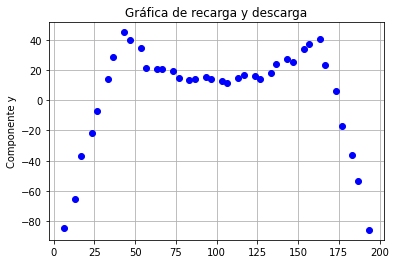

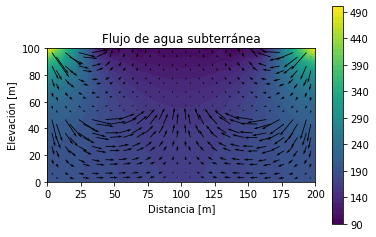

In [9]:
# Ploteo de la solucion
import matplotlib.pyplot as plt

plt.figure()
plt.plot(datos[361:399,0],datos[361:399,6],'bo')
plt.title('Gráfica de recarga y descarga')
plt.ylabel('Componente y')
plt.grid()

plt.figure()
carga=plot(u)
flujo=plt.quiver(xx,yy,datos[:,5],datos[:,6])
plt.colorbar(carga)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
#plt.colorbar(im)
#plot(mesh)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()